In this notebook, we continue on the track to study the track of hedging in the world of FX option still from a trader sitting in a exotic desk in a investment bank. As we've seen in the previous notebooks ([Hedging a book of exotics options](exotic-book.ipynb)) we have cover the basics on how to hedge a book of FX exotics, both in the case where we are hedging under the Black-Scholes model and in the case where we have a volatility smile and hedge options with the same expiration using the VV method ([Hedging a book of exotics options using the Vanna-Volga](exotic-book-vanna-volga.ipynb)), in this notebook we are going to take a even further step since we are going to leverage the whole IV surface to hedge our portfolio made of different options with different strikes and expirations. In this case, I've decided to leverage the local volatility model and price using the Finite Difference method. The assets that we are considering are thus under the following dynamics:

$$
\begin{align*}
dS_t &= (r_d - r_f) S_t \, dt + \sigma(S, t) S_t \, dW_t^d, \\ 
dB^d_t &= r_d B^d_t\, dt, \\ 
dB^f_t &= r_f B^f_t\, dt
\end{align*}
$$

In [171]:
from typing import List
from functools import partial
from dataclasses import dataclass
from typing import Callable, List, Union, Tuple

import QuantLib as ql
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [172]:
class FxVanillaOptionFactory:
    """
    Helper class used to create Vanilla FX Options and related objects used to price those
    """

    def __init__(self, spot: ql.QuoteHandle, expiry: ql.Date, option_type: ql.Option):
        self.exercise_ = ql.EuropeanExercise(expiry)
        self.option_type_ = option_type
        self.spot_ = spot
    
    def get_option(self, strike: float) -> ql.VanillaOption:
        payoff = ql.PlainVanillaPayoff(self.option_type_, strike)
        return ql.VanillaOption(payoff, self.exercise_)
    
    def get_gk_process(self, 
                       domesitc_ts_handle: ql.YieldTermStructureHandle, 
                       foreign_ts_handle: ql.YieldTermStructureHandle, 
                       vol_ts_handle: ql.BlackVolTermStructureHandle):
        """
        Construct and return a QuantLib Garman-Kohlhagen process for FX option pricing.

        Parameters:
            domesitc_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the domestic (quote) currency.
            foreign_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the foreign (base) currency.
            vol_ts_handle (ql.BlackVolTermStructureHandle): The Black volatility term structure handle for the FX rate.

        Returns:
            ql.GarmanKohlagenProcess: The stochastic process object used for pricing FX options under the Garman-Kohlhagen model.
        """
        return ql.GarmanKohlagenProcess(
            self.spot_,
            foreign_ts_handle,
            domesitc_ts_handle,
            vol_ts_handle
        )
    
    @staticmethod
    def assign_analyitcal_price_engine(option: ql.Option, process: ql.StochasticProcess):
        engine = ql.AnalyticEuropeanEngine(process)
        option.setPricingEngine(engine)

In [173]:
class FxBarrierOptionFactory:
    """
    Helper class used to create Vanilla FX Options and related objects used to price those
    """

    def __init__(self, spot: ql.QuoteHandle, option_type: ql.Option):
        self.option_type_ = option_type
        self.spot_ = spot
    
    def get_option(self, strike: float, exercise: ql.Exercise, barrier: float, barrier_t: ql.Barrier) -> ql.BarrierOption:
        payoff = ql.PlainVanillaPayoff(self.option_type_, strike)
        return ql.BarrierOption(barrier_t, barrier, 0.0, payoff, exercise)
    
    def get_gk_process(self,
                       domesitc_ts_handle: ql.YieldTermStructureHandle, 
                       foreign_ts_handle: ql.YieldTermStructureHandle, 
                       vol_ts_handle: ql.BlackVolTermStructureHandle):
        """
        Construct and return a QuantLib Garman-Kohlhagen process for FX option pricing.

        Parameters:
            domesitc_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the domestic (quote) currency.
            foreign_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the foreign (base) currency.
            vol_ts_handle (ql.BlackVolTermStructureHandle): The Black volatility term structure handle for the FX rate.

        Returns:
            ql.GarmanKohlagenProcess: The stochastic process object used for pricing FX options under the Garman-Kohlhagen model.
        """
        return ql.GarmanKohlagenProcess(
            self.spot_,
            foreign_ts_handle,
            domesitc_ts_handle,
            vol_ts_handle
        )
    
    def get_bs_process(self,
                       domesitc_ts_handle: ql.YieldTermStructureHandle, 
                       foreign_ts_handle: ql.YieldTermStructureHandle, 
                       vol_ts_handle: ql.BlackVolTermStructureHandle,
                       local_vol_handle: ql.LocalVolTermStructureHandle):
        """
        Construct and return a QuantLib Garman-Kohlhagen process for FX option pricing.

        Parameters:
            domesitc_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the domestic (quote) currency.
            foreign_ts_handle (ql.YieldTermStructureHandle): The yield term structure handle for the foreign (base) currency.
            vol_ts_handle (ql.BlackVolTermStructureHandle): The Black volatility term structure handle for the FX rate.

        Returns:
            ql.GarmanKohlagenProcess: The stochastic process object used for pricing FX options under the Garman-Kohlhagen model.
        """
        return ql.GeneralizedBlackScholesProcess(
            self.spot_,
            foreign_ts_handle,
            domesitc_ts_handle,
            vol_ts_handle,
            local_vol_handle
        )

    @staticmethod
    def assign_analyitcal_price_engine(option: ql.Option, process: ql.StochasticProcess):
        engine = ql.AnalyticBarrierEngine(process)
        option.setPricingEngine(engine)

    @staticmethod
    def assign_price_engine(option: ql.Option, engine: ql.PricingEngine):
        option.setPricingEngine(engine)

    @staticmethod
    def assign_vanna_volga_price_engine(
            option: ql.Option, 
            atm_dvol_handle: ql.DeltaVolQuoteHandle, 
            delta25_p_dvol_handle,
            delta25_c_dvol_handle,
            spot_handle: ql.QuoteHandle,
            usd_disc_ts: ql.YieldTermStructureHandle,
            eur_disc_ts: ql.YieldTermStructureHandle
        ):
        engine = ql.VannaVolgaBarrierEngine(
            atm_dvol_handle,
            delta25_p_dvol_handle, 
            delta25_c_dvol_handle, 
            spot_handle,
            usd_disc_ts,
            eur_disc_ts
        )
        option.setPricingEngine(engine)

In [174]:
class SpotFX(ql.Instrument):

    def __init__(self, spot_quote: ql.Quote):
        self._spot_quote = spot_quote

    def NPV(self) -> float:
        return self._spot_quote.value()
    

class NullInstrument(ql.Instrument):

    def __init__(self):
        pass

    def NPV(self) -> float:
        return 0.0


@dataclass
class Position:
    instrument: ql.Instrument
    notional: float

    def NPV(self) -> float:
        return self.instrument.NPV() * self.notional
    
    def raw_sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        h = kwargs.get("h")
        k = kwargs.get("k")

        if k:
            return greek_fn(self.instrument, h=h, k=k)
        else:
            return greek_fn(self.instrument, h=h)

    def sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        greek_value = self.raw_sensitivity(greek_fn, **kwargs)

        return greek_value * self.notional
    
class BarrierPosition(Position):

    def __init__(self, instrument: ql.Instrument, notional: float, backup_instrument: Union[ql.Instrument, NullInstrument]):
        super().__init__(instrument, notional)
        self._backup_instrument = backup_instrument

    def NPV(self) -> float:
        try:
            npv = super().NPV()
        except RuntimeError:
            npv = self._backup_instrument.NPV()

        return npv
    
    def raw_sensitivity(self, greek_fn: Callable, **kwargs) -> float:
        try:
            greek_val = super().raw_sensitivity(greek_fn, **kwargs)
        except RuntimeError:
            h = kwargs.get("h")
            k = kwargs.get("k")

            if k:
                greek_val = greek_fn(self._backup_instrument, h=h, k=k)
            else:
                greek_val = greek_fn(self._backup_instrument, h=h)

        return greek_val

In [175]:
def strike_from_delta(spot: float,
                      delta: float,
                      time: float,
                      option: ql.Option,
                      vol: float,
                      dom_curve: ql.DiscountCurve, 
                      for_curve: ql.DiscountCurve, 
                      delta_vol_quote_type: ql.DeltaVolQuote = ql.DeltaVolQuote.Spot
                      ) -> float:
    """
    Calculate the strike for a given delta-vol quote

    Parameters:
        spot (float):
        delta (float):
        time (float):
        option (ql.Option):
        vol (float):
        dom_curve (ql.DiscountCurve):
        for_curve (ql.DiscountCurve):
        delta_vol_quote_time (ql.DeltaVolQuote):

    Returns:
        float: The corresponding strike for the given input parameters 
    """
    calc = ql.BlackDeltaCalculator(
        option,
        delta_vol_quote_type,
        spot,
        for_curve.discount(time),
        dom_curve.discount(time),
        vol * np.sqrt(time)
    )
    return calc.strikeFromDelta(delta)

In [176]:
def create_strike_iv_surf(
        spot: float, 
        dom_curve: ql.DiscountCurve, 
        for_curve: ql.DiscountCurve, 
        deltas: List[float], 
        options: List[ql.Option], 
        times: List[float], 
        ivs: np.ndarray) -> np.ndarray:
    strikes = np.empty_like(ivs)

    for i, t in enumerate(times):
        for j, (d, o) in enumerate(zip(deltas, options)):
            strikes[i, j] = strike_from_delta(
                spot,
                d,
                t,
                o,
                ivs[i][j],
                dom_curve,
                for_curve)
    
    return strikes

# Market Data

Let's assume that we are an USD based desk and we are dealing with EURUSD exotics. The initial market data at time $t = 0$ is the following

$$
\begin{align*}
    S_0 &= 1.18 \\
    Date(Today) &= 12/12/2025 \\
    r_{USD} &= 0.03 \\
    r_{EUR} &= 0.02 \\
\end{align*}
$$

With the following Implied Vol surface

| | $10\Delta p$ | $25\Delta p$ | ATM | $25\Delta c$ | $10\Delta c$ |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **1W** | 13.50% | 12.00% | 9.50% | 8.50% | 9.50% |
| **1M** | 13.00% | 11.50% | 9.00% | 8.00% | 9.00% |
| **3M** | 12.50% | 11.00% | 9.50% | 8.50% | 9.50% |
| **1Y** | 12.00% | 10.50% | 10.00% | 9.50% | 10.50% |

For the sake of simplicity we consider that the interest rate term structures for the USD and EUR are both flat

> Note in the FX option world, IVs are quoted as a delta-vol pairs for each maturity.

In [ ]:
#| echo: true
EUR_USD = 1.18
today = ql.Date(12, ql.December, 2025)
ref_date = today
calendar = ql.NullCalendar()
dc = ql.Actual365Fixed()
r_d = 0.0325
r_f = 0.02

ql.Settings.instance().evaluationDate = today

In [ ]:
#| echo: true
spot_quote = ql.SimpleQuote(EUR_USD)
spot_handle = ql.QuoteHandle(spot_quote)

deltas = [-0.10, -0.25, 0.5, 0.25, 0.10]
option_types = [ql.Option.Put, ql.Option.Put, ql.Option.Call, ql.Option.Call, ql.Option.Call]
maturity_1y = calendar.advance(today, ql.Period(1, ql.Years))
maturity_3m = calendar.advance(today, ql.Period(3, ql.Months))
maturity_6m = calendar.advance(today, ql.Period(6, ql.Months))
maturity_1m = calendar.advance(today, ql.Period(1, ql.Months))
maturity_1w = calendar.advance(today, ql.Period(1, ql.Weeks))
maturities = [
    maturity_1w,
    maturity_1m,
    maturity_3m,
    maturity_1y
]
times = [dc.yearFraction(today, m) for m in maturities]
# Vol surface
ivs = np.array([
    # 0.10P, 0.25P, ATM,  0.25C, 0.10C
    [0.135, 0.12,  0.095, 0.090, 0.095],  # 1W 
    [0.130, 0.115, 0.090, 0.080, 0.090],  # 1M
    [0.125, 0.110, 0.095, 0.085, 0.095],  # 3M
    [0.120, 0.105, 0.100, 0.095, 0.105],  # 1Y
])

In [ ]:
#| echo: true
# Rates TS
domestic_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r_d, dc))
foreign_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r_f, dc))

In [ ]:
#| echo: true
# Discount curves
eur_dates = [ql.Date(27, ql.August, 2025), ql.Date(27, ql.August, 2026), ql.Date(27, ql.August, 2027)]
eur_dfs = [1.0, 0.98, 0.95]
eur_curve = ql.DiscountCurve(eur_dates, eur_dfs, dc)
eur_curve.enableExtrapolation()
eur_disc_ts = ql.YieldTermStructureHandle(eur_curve)

usd_dates = [ql.Date(27, ql.August, 2025), ql.Date(27, ql.August, 2026), ql.Date(27, ql.August, 2027)]
usd_dfs = [1.0, 0.985, 0.96]
usd_curve = ql.DiscountCurve(usd_dates, usd_dfs, dc)
usd_curve.enableExtrapolation()
usd_disc_ts = ql.YieldTermStructureHandle(usd_curve)

Let's also suppose that the following discount curve: 

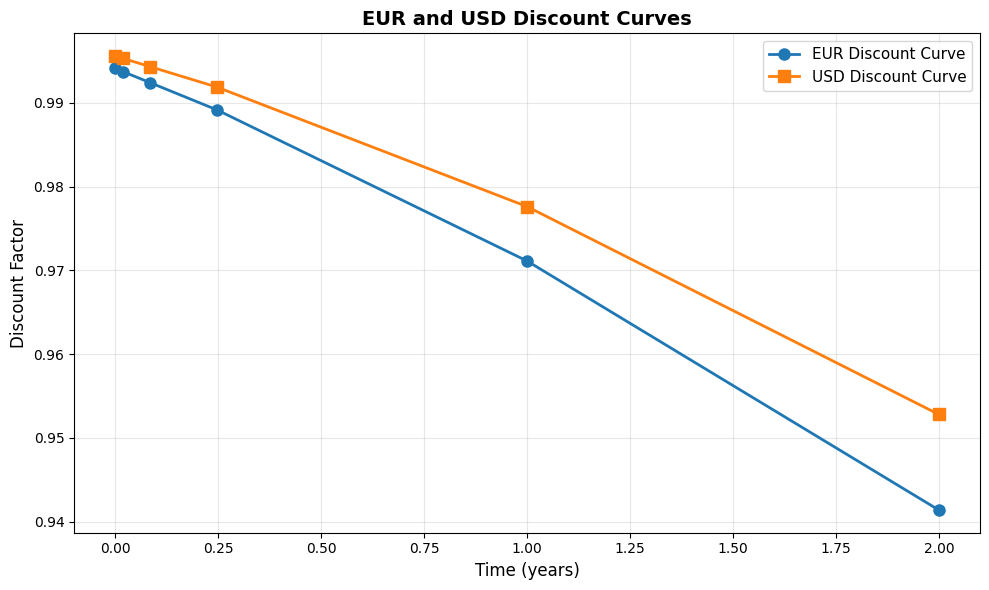

In [181]:
# Plot discount curves
fig, ax = plt.subplots(figsize=(10, 6))

# Get time points for plotting
plot_dates = [today] + maturities + [calendar.advance(today, ql.Period(2, ql.Years))]
plot_times = [dc.yearFraction(today, d) for d in plot_dates]

# Get discount factors
eur_dfs_plot = [eur_curve.discount(d) for d in plot_dates]
usd_dfs_plot = [usd_curve.discount(d) for d in plot_dates]

# Plot both curves
ax.plot(plot_times, eur_dfs_plot, marker='o', linewidth=2, markersize=8, label='EUR Discount Curve')
ax.plot(plot_times, usd_dfs_plot, marker='s', linewidth=2, markersize=8, label='USD Discount Curve')

ax.set_xlabel('Time (years)', fontsize=12)
ax.set_ylabel('Discount Factor', fontsize=12)
ax.set_title('EUR and USD Discount Curves', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

Since we have a sticky delta volatility surface, we need to turn the surface into a sticky strike volatility surface in order to make `QuantLib` make use of those IVs when pricing the exotics. To do that let's use the `create_strike_iv_surf` helper function defined above. `create_strike_iv_surf` uses the `ql.BlackDeltaCalculator` class which allows us to get the strike from the delta-vol quote according the specific delta quote convetion that we are using.

In [ ]:
#| echo: true
strikes = create_strike_iv_surf(EUR_USD, usd_curve, eur_curve, deltas, option_types, times, ivs)

The corresponding strikes for each $(\Delta,T)$ tuple are:

In [183]:
pd.DataFrame(strikes, 
             columns=["10D P", "25D P", "ATM", "25D C", "10D C"], 
             index=["1W", "1M", "3M", "1Y"])

,10D P,25D P,ATM,25D C,10D C
1W,1.152382,1.167127,1.180212,1.190167,1.200282
1M,1.125401,1.154811,1.180866,1.199518,1.221262
3M,1.093388,1.140628,1.182536,1.216533,1.256383
1Y,1.025369,1.112431,1.189692,1.268784,1.363115


Since, now we have a set of IV with different strikes for each expiration, we need to find a way to build the IV surface using this data. One efficient and common way to do that is using the Andersen-Huge interpolation [see @vol-interpol] method, which allows us to achieve this goal. In a nuthsell, the Andreasen and Huge have introduced an efficient and arbitrage free volatility interpolation method based on a one step finite difference implicit Euler scheme applied to a local volatility parametrization. Probably the most notable use case is the generation of a local volatility surface from a set of option quotes.

QuantLib provides us with a series of classes that can help us to build both the IV and the local surface from the IV data, using the Andersen-Huge method. First and foremost, we need to build a calibration set, which is basically a list of Tuple made by the option and the iv relative to that option `(option, ivs_quote)`, and then we can create an instance of the `ql.AndersenHugeVolatilityInterpl` with the calibration set created, that is the class that is going to handle the interpolation. Then we need to create the relative Implied vol and Local vol adapter the `ql.AndersenHugeVolatilityAdapter` and the `ql.AndersenHugeLocalAdapter` respectively. Those are the instances that resprents the BlackVarianceTermStructure and the LocalVolTermStructure that we need to further wrap into a `RelinkableHandle`. 

Why a `RenilableHandle` you might ask? Well it's because it will come in handyh to us when calculating the sensitivities, rembember a `RelinkableHandle` can be link to another term structure after it is first created, unlike a plain handle.

In [ ]:
#| echo: true
# Calibration of vol surfaces
def calibrate_vol_surface(strikes: Union[List[List[float]], np.ndarray], 
                          options: List[ql.Option],
                          maturities: List[float], 
                          ivs: np.array
                        ) -> Tuple[ql.BlackVolTermStructure, ql.LocalVolTermStructure]:
    """
    Calibrate the given ivs quotes and build a BlackVolTermStructure and a LocalVolTermStructure
    
    Parameters:
        strikes (Union[List[List[float]], np.ndarray]): the strikes of the volatility surface
        options (List[ql.Option]): the types of option a specific strike is referring to
        maturities (List[float]): list of maturieties of the vol surface
        ivs (np.ndarray): the iv surface data
    
    Return:
        ql.Tuple[ql.BlackVolTermStructure, ql.LocalVolTermStructure]: tuple contaning the calibrate black vol term structure 
                                                                    and the local vol term structure
    """
    calibration_set = ql.CalibrationSet()

    n, m = len(maturities), len(options)

    for i in range(n):
        for j in range(m):
            payoff = ql.PlainVanillaPayoff(options[i], strikes[i][j])
            maturity = ql.EuropeanExercise(maturities[i])

            calibration_set.push_back((ql.VanillaOption(payoff, maturity), ql.SimpleQuote(ivs[i][j])))

    ah_interpolation = ql.AndreasenHugeVolatilityInterpl(calibration_set, \
                            spot_handle, domestic_ts, foreign_ts)
    ah_vol_surf = ql.AndreasenHugeVolatilityAdapter(ah_interpolation) # IV surface
    ah_local_vol = ql.AndreasenHugeLocalVolAdapter(ah_interpolation) # LV surface

    return ah_vol_surf, ah_local_vol

ah_vol_surf, ah_local_vol = calibrate_vol_surface(strikes, option_types, maturities, ivs)
black_vol_surf_handle = ql.RelinkableBlackVolTermStructureHandle(ah_vol_surf)
local_vol_surf_handle = ql.RelinkableLocalVolTermStructureHandle(ah_local_vol)

Now that we have constructed the vol surfaces, let's now visualized how they look:

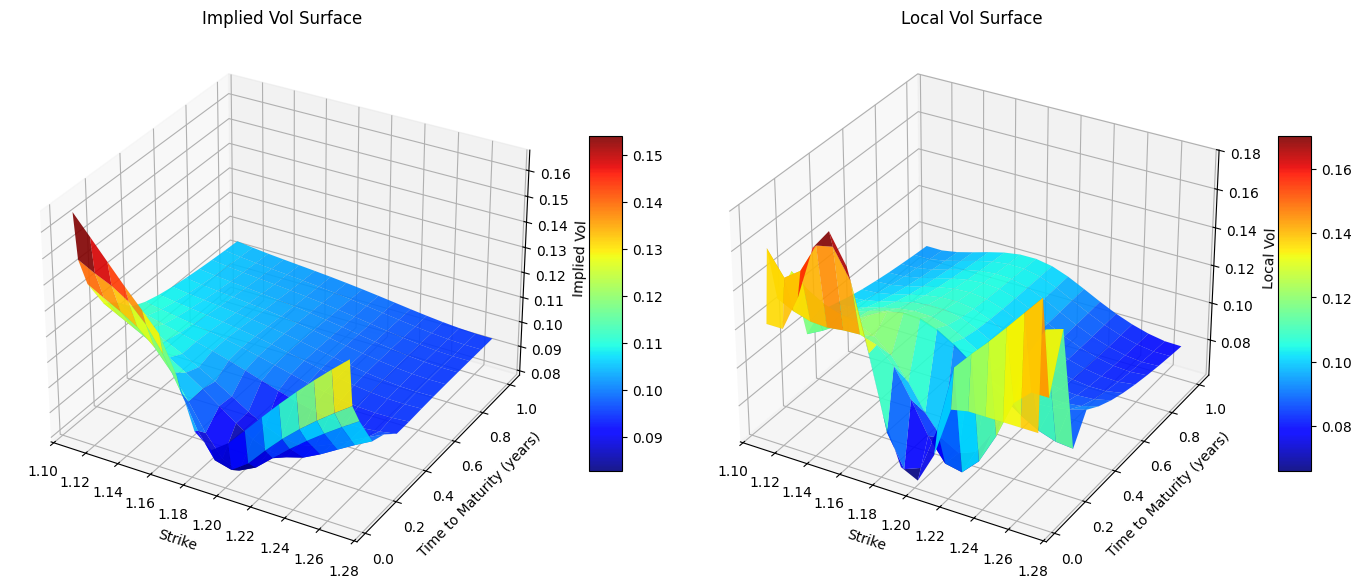

In [185]:
maturities_to_plot = [
    calendar.advance(today, ql.Period(1, ql.Weeks)),
    calendar.advance(today, ql.Period(2, ql.Weeks))] + \
    [calendar.advance(today, ql.Period(i, ql.Months)) for i in range(1, 12, 1)] + \
    [calendar.advance(today, ql.Period(1, ql.Years))]
times_to_plot = [dc.yearFraction(today, m) for m in maturities_to_plot]
strikes_to_plot = np.arange(1.11, 1.28, 0.01)
S, T = np.meshgrid(strikes_to_plot, times_to_plot)

IV = np.zeros_like(T)
LV = np.zeros_like(T)

for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        IV[i, j] = ah_vol_surf.blackVol(T[i, j], S[i, j], True)
        LV[i, j] = ah_local_vol.localVol(T[i, j], S[i, j])

fig = plt.figure(figsize=(14, 7))
ax_1 = fig.add_subplot(1,2,1, projection='3d')
ax_2 = fig.add_subplot(1,2,2, projection='3d')

iv_surf = ax_1.plot_surface(S, T, IV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_1.set_xlabel('Strike')
ax_1.set_ylabel('Time to Maturity (years)')
ax_1.set_zlabel('Implied Vol')
ax_1.set_title('Implied Vol Surface')
fig.colorbar(iv_surf, ax=ax_1, shrink=0.5, aspect=10)

lv_surf = ax_2.plot_surface(S, T, LV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_2.set_xlabel('Strike')
ax_2.set_ylabel('Time to Maturity (years)')
ax_2.set_zlabel('Local Vol')
ax_2.set_title('Local Vol Surface')
fig.colorbar(lv_surf, ax=ax_2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


Just a reminder $IV_{\text{surface}} \ne LV_{\text{surface}}$, they are related but they are not the same thing. IVs represent a sort of estimate of the average future volatility of the underlying during the option's lifetime. In a way, IVs is a "global" measure of volatility, in contrast to the local volatility $\sigma_{LV}$ at any spot price and time.

In [186]:
call_barrier_factory = FxBarrierOptionFactory(spot_handle, ql.Option.Call)
put_barrier_factory = FxBarrierOptionFactory(spot_handle, ql.Option.Put)

In [187]:
process = ql.GeneralizedBlackScholesProcess(
    spot_handle,
    foreign_ts,
    domestic_ts,
    black_vol_surf_handle,
    local_vol_surf_handle
)
process_25c = call_barrier_factory.get_gk_process(
    domestic_ts,
    foreign_ts,
    ql.BlackVolTermStructureHandle(ql.BlackConstantVol(ref_date, calendar, ivs[-1, -2], dc)))

Since we are using the local vol model, one way to price option is by using the Finite Difference method.
QuantLib provides us with the `FdBlackScholesBarrierEngine` class to achieve that, keep in mind that we need to set `useLocalVol=True`, thus we can use the local volatility function when running the pricing engine.

In [ ]:
#| echo: true
engine = ql.FdBlackScholesBarrierEngine(
    process,
    200,
    400,
    0,
    ql.FdmSchemeDesc.Douglas(),
    True, # localVol has to be True
    0.1)

## Exotics Book

Here's how the trader book is composed of:

1st Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Call} \\
    \text{Notional} &= \$1000000 \\
    T &= 1.0 \\
    \text{Barrier} &= 1.30 \\
    \text{Strike} &= 25\Delta c \\
    \text{Barrier Type} &= \text{Up and Out}
\end{align*}
$$

In [ ]:
#| echo: true
# Barrier 1
notional = 1_000_000
barrier = 1.30
barrier_type = ql.Barrier.UpOut
exercise = ql.EuropeanExercise(maturity_1y)
strike = strike_from_delta(
    EUR_USD,
    0.25,
    times[-1],
    ql.Option.Call,
    ivs[-1, -2],
    usd_curve,
    eur_curve
)

barrier_25d_130b = call_barrier_factory.get_option(strike, exercise, barrier, barrier_type)
barrier_1 = BarrierPosition(barrier_25d_130b, notional, NullInstrument())

2nd Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Call} \\
    \text{Notional} &= \$2000000 \\
    T &= 0.5 \\
    \text{Barrier} &= 1.08 \\
    \text{Strike} &= 25\Delta c \\
    \text{Barrier Type} &= \text{Down and Out}
\end{align*}
$$

In [ ]:
#| echo: true
# Barrier 2
notional = 2_000_000
barrier = 1.08
barrier_type = ql.Barrier.DownOut
exercise = ql.EuropeanExercise(maturity_6m)
strike = strike_from_delta(
    EUR_USD,
    0.25,
    dc.yearFraction(today, maturity_6m),
    ql.Option.Call,
    0.09, # Interpolated value
    usd_curve,
    eur_curve
)

barrier_25d_108b = call_barrier_factory.get_option(strike, exercise, barrier, barrier_type)
barrier_2 = BarrierPosition(barrier_25d_108b, notional, NullInstrument())

3rd Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Call} \\
    \text{Notional} &= \$1000000 \\
    T &= 0.25 \\
    \text{Barrier} &= 1.20 \\
    \text{Strike} &= 25\Delta c \\
    \text{Barrier Type} &= \text{Up and In}
\end{align*}
$$

In [ ]:
#| echo: true
# Barrier 3
notional = 1_000_000
barrier = 1.20
barrier_type = ql.Barrier.UpIn
exercise = ql.EuropeanExercise(maturity_3m)
strike = strike_from_delta(
    EUR_USD,
    0.25,
    dc.yearFraction(today, maturity_3m),
    ql.Option.Call,
    ivs[-2, -2],
    usd_curve,
    eur_curve
)
call_vanilla_factory = FxVanillaOptionFactory(spot_handle, maturity_1y, ql.Option.Call)

barrier_25d_120b = call_barrier_factory.get_option(strike, exercise, barrier, barrier_type)
backup_vanilla = call_vanilla_factory.get_option(strike)
FxVanillaOptionFactory.assign_analyitcal_price_engine(backup_vanilla, process_25c)
barrier_3 = BarrierPosition(barrier_25d_120b, notional, backup_vanilla)

4th Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Put} \\
    \text{Notional} &= \$1000000 \\
    T &= 0.25 \\
    \text{Barrier} &= 1.05 \\
    \text{Strike} &= 25\Delta p \\
    \text{Barrier Type} &= \text{Down and Out}
\end{align*}
$$

In [ ]:
#| echo: true
# Barrier 4
notional = 1_000_000
barrier = 1.05
barrier_type = ql.Barrier.DownOut
exercise = ql.EuropeanExercise(maturity_3m)
strike = strike_from_delta(
    EUR_USD,
    -0.25,
    dc.yearFraction(today, maturity_3m),
    ql.Option.Put,
    ivs[-2, 2],
    usd_curve,
    eur_curve
)

barrier_25d_105b = put_barrier_factory.get_option(strike, exercise, barrier, barrier_type)
barrier_4 = BarrierPosition(barrier_25d_105b, notional, NullInstrument())


5th Barrier

$$
\begin{align*}
    \text{Option type} &= \text{Put} \\
    \text{Notional} &= \$1000000 \\
    \text{Barrier} &= 1.25 \\
    T &= 0.0833 \\
    \text{Strike} &= 25\Delta p \\
    \text{Barrier Type} &= \text{Up and Out}
\end{align*}
$$

In [ ]:
#| echo: true
# Barrier 5
notional = 2_000_000
barrier = 1.25
barrier_type = ql.Barrier.UpOut
exercise = ql.EuropeanExercise(maturity_1m)
strike = strike_from_delta(
    EUR_USD,
    -0.25,
    dc.yearFraction(today, maturity_1m),
    ql.Option.Put,
    ivs[1, 2],
    usd_curve,
    eur_curve
)

barrier_25d_105b = put_barrier_factory.get_option(strike, exercise, barrier, barrier_type)
barrier_5 = BarrierPosition(barrier_25d_105b, notional, NullInstrument())


In [ ]:
#| echo: true

book: List[BarrierPosition] = [barrier_1, barrier_2, barrier_3, barrier_4, barrier_5]

for ins in book:
    FxBarrierOptionFactory.assign_price_engine(ins.instrument, engine)

Now we have setup our book, let's see what's the premium on those options.

In [195]:
premiums = [opt.NPV() for opt in book]

for i, p in enumerate(premiums):
    print(f"Barrier {i + 1}, price ${p:.2f}")

Barrier 1, price $260.39
Barrier 2, price $26721.44
Barrier 3, price $7822.55
Barrier 4, price $4510.61
Barrier 5, price $13603.77


In [196]:
book_value = sum(premiums)

print("The total book value is ${book_value}")

The total book value is ${book_value}


# Bucketed sensitivities

When dealing with vol surfaces or smiles, to calculate the sensitivity w.r.t. the volatility does not result trival as when we are dealing with a single vol like in BS model. As shown in the Hedging a book of exotic options with VV method, in case we have a smile we can calculate the sensitivities to the various movements of the volatility smile (paralallel shift, varying the skew, and the curvature), and those ideas can be also applied to the whole vol surface.

Another possible way, to get those vega sensitivities is to calculate how the prices are sensible to each single IV variation, in this way we get the so called bucket sensitivites.

For example we want to know how the price of an exotic is sensible to the variation to the $\sigma_{(0.10\Delta P, 1M)}$. To the get that we can use the forward finte difference formula: 

$$
\frac{\partial V}{\partial \sigma_{(0.10\Delta P, 1M)}} = \frac{V(\sigma_{(0.10\Delta P, 1M)} + \varepsilon, \cdot) - V(\sigma_{(0.10\Delta P, 1M)}, \cdot)}{\varepsilon}
$$

By repeating this process for all vols of the IV surface we get a matrix of the bucket sensitivities:

$$
\text{Bucket Sensitivities} = \left[
\begin{array}{c|cccc}
    & \text{10$\Delta$ P} & \text{25$\Delta$ P} & \text{ATM} & \text{25$\Delta$ C} & \text{10$\Delta$ C} \\
    \hline
    \text{1W}   & s_{11} & s_{12} & s_{13} & s_{14} & s_{15} \\
    \text{1M}   & s_{21} & s_{22} & s_{23} & s_{24} & s_{25} \\
    \text{3M}  & s_{31} & s_{32} & s_{33} & s_{34} & s_{35} \\
    \text{1Y}  & s_{41} & s_{42} & s_{43} & s_{44}  & s_{45} \\
\end{array}
\right]
$$

The methodology to use to calculate the sensitivities w.r.t. the volatility surface is up the trader/trading desk, on how they want those sensitivities ...

>TODO: add risk surface explanation

To visualized the effect of those single bumps of the single IVs, let's for example bump by $1\%$ the ATM vol with maturity 1 year, and visualized how the IV and LV surfaces are changing. 

In [197]:
ivs[-1, 2] += 0.01

new_ah_vol_surf, new_ah_local_vol = calibrate_vol_surface(strikes, option_types, maturities, ivs)
black_vol_surf_handle.linkTo(new_ah_vol_surf)
local_vol_surf_handle.linkTo(new_ah_local_vol)

ivs[-1, 2] -= 0.01

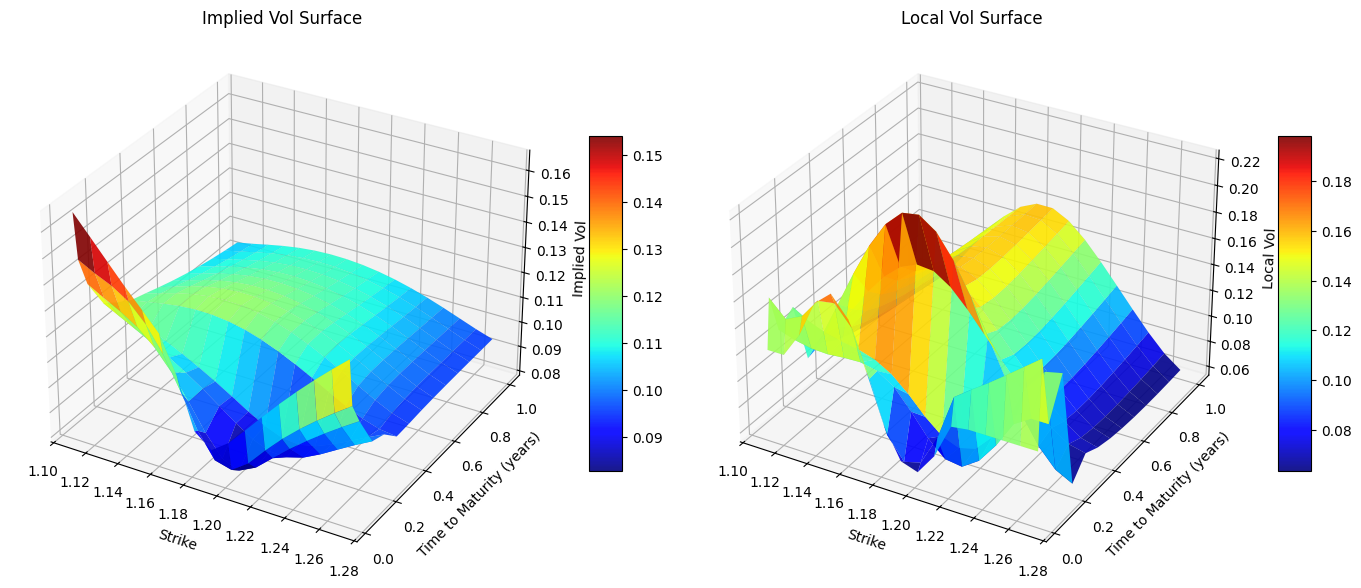

In [198]:
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        IV[i, j] = black_vol_surf_handle.blackVol(T[i, j], S[i, j], True)
        LV[i, j] = local_vol_surf_handle.localVol(T[i, j], S[i, j])

fig = plt.figure(figsize=(14, 7))
ax_1 = fig.add_subplot(1,2,1, projection='3d')
ax_2 = fig.add_subplot(1,2,2, projection='3d')

iv_surf = ax_1.plot_surface(S, T, IV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_1.set_xlabel('Strike')
ax_1.set_ylabel('Time to Maturity (years)')
ax_1.set_zlabel('Implied Vol')
ax_1.set_title('Implied Vol Surface')
fig.colorbar(iv_surf, ax=ax_1, shrink=0.5, aspect=10)

lv_surf = ax_2.plot_surface(S, T, LV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_2.set_xlabel('Strike')
ax_2.set_ylabel('Time to Maturity (years)')
ax_2.set_zlabel('Local Vol')
ax_2.set_title('Local Vol Surface')
fig.colorbar(lv_surf, ax=ax_2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


The IV surface does change a bit, but where we can see a big changment is in LV surface where a new hump appears at the end of the surface. Let's now see how the prices of the exotics have changed with this new vol surfaces.

In [ ]:
#| echo: true
new_premiums = [opt.NPV() for opt in book]
new_premiums

[555.7614339685688,
 31789.433532155144,
 7822.54562563613,
 4510.6110117102935,
 13603.771705059622]

In [ ]:
#| echo: true
np.array(premiums) - np.array(new_premiums)

array([ -295.3701985 , -5067.99548249,     0.        ,     0.        ,
           0.        ])

As we can see the only options where the price has varied is the 1st barrier, which is the only barrier that has expiration time 1Y. ...
You might wonder what does bump another vol with shorted maturity, will that affect also the exotics with maturities greater than that maturity? Let's bump for example by 1bp the ATM, 1M implied vol and see the effects on the other exotics prices.

In [201]:
ivs[1, 2] += 0.01

new_ah_vol_surf, new_ah_local_vol = calibrate_vol_surface(strikes, option_types, maturities, ivs)
black_vol_surf_handle.linkTo(new_ah_vol_surf)
local_vol_surf_handle.linkTo(new_ah_local_vol)

ivs[1, 2] -= 0.01

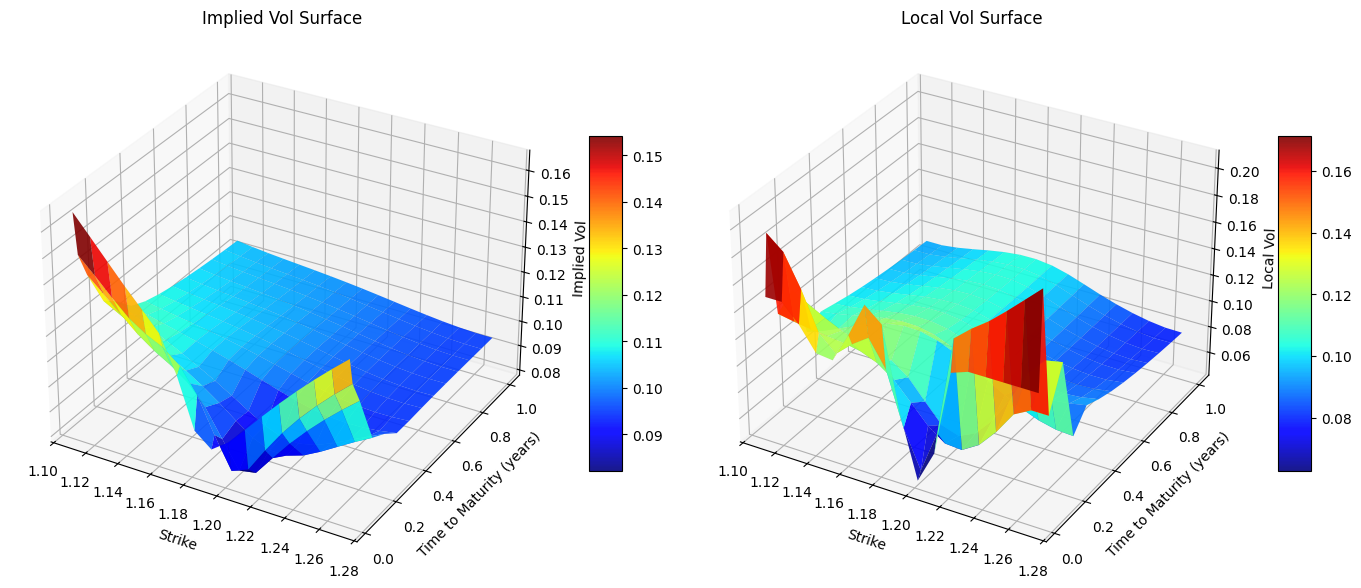

In [202]:
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        IV[i, j] = black_vol_surf_handle.blackVol(T[i, j], S[i, j], True)
        LV[i, j] = local_vol_surf_handle.localVol(T[i, j], S[i, j])

fig = plt.figure(figsize=(14, 7))
ax_1 = fig.add_subplot(1,2,1, projection='3d')
ax_2 = fig.add_subplot(1,2,2, projection='3d')

iv_surf = ax_1.plot_surface(S, T, IV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_1.set_xlabel('Strike')
ax_1.set_ylabel('Time to Maturity (years)')
ax_1.set_zlabel('Implied Vol')
ax_1.set_title('Implied Vol Surface')
fig.colorbar(iv_surf, ax=ax_1, shrink=0.5, aspect=10)

lv_surf = ax_2.plot_surface(S, T, LV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_2.set_xlabel('Strike')
ax_2.set_ylabel('Time to Maturity (years)')
ax_2.set_zlabel('Local Vol')
ax_2.set_title('Local Vol Surface')
fig.colorbar(lv_surf, ax=ax_2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


In [203]:
for i, var in enumerate(np.array(premiums) - np.array([opt.NPV() for opt in book])):
    print(f"Barrier {i + 1}, ATM 1M IV bump sensitivity: $ {var:.2f}")

Barrier 1, ATM 1M IV bump sensitivity: $ -0.10
Barrier 2, ATM 1M IV bump sensitivity: $ 17.19
Barrier 3, ATM 1M IV bump sensitivity: $ 4.48
Barrier 4, ATM 1M IV bump sensitivity: $ -22.66
Barrier 5, ATM 1M IV bump sensitivity: $ -565.39


Now we see how all options in the book have been impacted by this vol bump, that's because all the options in the book have an expiration after 1Y, thus this will impact their price. Of course Barrier 5 will be the one with more price impact, since it expires in 1 month, but we can see that also in options expirying in 3 months and 6 months there is a price impact.

Let's apply the process above for all the IVs in the original IV surface and calculate those bucket sensitivities.

In [ ]:
#| echo: true
bucket_sens = np.zeros_like(ivs)
delta_vol = 1.0e-08

for i in range(len(ivs)):
    for j in range(len(ivs[0])):
        ivs[i, j] += delta_vol

        tmp_strikes = create_strike_iv_surf(EUR_USD, usd_curve, eur_curve, deltas, option_types, times, ivs)

        new_ah_vol_surf, new_ah_local_vol = calibrate_vol_surface(tmp_strikes, option_types, maturities, ivs)
        black_vol_surf_handle.linkTo(new_ah_vol_surf)
        local_vol_surf_handle.linkTo(new_ah_local_vol)

        new_book_value = sum([opt.NPV() for opt in book])

        bucket_sens[i, j] = (new_book_value - book_value) / delta_vol

        ivs[i, j] -= delta_vol

In [205]:
pd.DataFrame(bucket_sens, 
             columns=["10D P", "25D P", "ATM", "25D C", "10D C"], 
             index=["1W", "1M", "3M", "1Y"]
            )

,10D P,25D P,ATM,25D C,10D C
1W,-1878.530020,5996.552500,-7096.302579,3011.398803,974.274008
1M,-11133.617227,168080.302683,41107.244760,-11645.406630,1430.459088
3M,-153599.417536,173253.199318,40819.460264,250610.804505,49760.293768
1Y,15323.454136,-176753.786945,341937.783378,346704.848926,-71231.295442


How do we hedge those bucketed sensitivities? Well, we can do it with plain vanilla options, ...

$$
s_{ij} = w_{ij} \frac{\partial C_{BS}(\sigma{ij})}{\partial \sigma_{ij}}  \Rightarrow w_{ij} = \frac{s_{ij}}{\frac{\partial C_{BS}(\sigma{ij})}{\partial \sigma_{ij}}} 
$$

In [ ]:
#| echo: true
vanilla_options = np.zeros_like(bucket_sens).tolist()

for i in range(len(vanilla_options)):
    for j in range(len(vanilla_options[0])):
        maturity = maturities[i]
        option_type = option_types[j]
        strike = strikes[i, j]
        process = ql.GarmanKohlagenProcess(
            spot_handle,
            foreign_ts,
            domestic_ts,
            ql.BlackVolTermStructureHandle(
                ql.BlackConstantVol(ref_date, calendar, ivs[i, j], dc)
            )
        )

        payoff = ql.PlainVanillaPayoff(option_type, strike)
        vanilla_options[i][j] = ql.VanillaOption(payoff, ql.EuropeanExercise(maturity))
        vanilla_options[i][j].setPricingEngine(ql.AnalyticEuropeanEngine(process))

In [ ]:
#| echo: true
vegas = np.array([[opt.vega() * notional for opt in row] for row in vanilla_options])

In [ ]:
#| echo: true
vega_weights = bucket_sens / vegas
with np.printoptions(precision=3):
    print(vega_weights)

[[-0.033  0.058 -0.054  0.029  0.017]
 [-0.094  0.78   0.15  -0.052  0.012]
 [-0.778  0.477  0.088  0.656  0.231]
 [ 0.04  -0.251  0.372  0.446 -0.159]]


Now that we have found the weight for all the vanillas, let's now reduce the total $\Delta$ exposure of our portfolio. The weight for the spot position hedge is given by

$$
w_{\Delta} = \frac{\frac{\partial \text{book}}{\partial S}}{\sum_{ij} \frac{\partial C_{BS}^{ij}}{\partial S}}
$$

In [210]:
def central_diff(instrument: ql.Instrument, h: float, quote: ql.SimpleQuote) -> float:
    u0 = quote.value()
    quote.setValue(u0 + h)
    P_Plus = instrument.NPV()
    quote.setValue(u0 - h)
    P_Minus = instrument.NPV()

    quote.setValue(u0)
    
    return (P_Plus - P_Minus) / (2 * h)

delta = partial(central_diff, quote=spot_quote)

In [ ]:
#| echo: true
spot_change = 0.01 * spot_quote.value() / 2

delta_book = sum([pos.sensitivity(delta, h=spot_change) for pos in book])
delta_vanillas = sum([sum([opt.delta() * v_w * notional for opt, v_w in zip(row, v_row)]) for row, v_row in zip(vanilla_options, vega_weights)])

In [ ]:
#| echo: true
hedging_delta_weight = delta_book / delta_vanillas
hedging_delta_weight

np.float64(-0.23937887076554554)

In [ ]:
#| echo: true
vanillas_premiums = [[opt.NPV() * v_w * notional for opt, v_w in zip(row, v_row)] for row, v_row in zip(vanilla_options, vega_weights)]
spot_hedge_usd = hedging_delta_weight * notional * spot_handle.value()
hedging_str_premium = np.sum(vanillas_premiums) + spot_hedge_usd
bank_account_value = - hedging_str_premium + np.sum(premiums)

In [ ]:
#| echo: true
port_value = [hedging_str_premium - np.sum(premiums) + bank_account_value]

print(f"The portfolio value at time t = 0 is {port_value[0]}")

The portfolio value at time t = 0 is 0.0


## Changes of the hedging portfolio with the changes of the market conditions

Now that we have setup our hedging portfolio see verify how its will change as the spot and vol surface change. Let's assume that in a 2-day period the spot went go down by 200 pips, the ATM vol went up by $0.5\%$ while the the 25 $\Delta$ Put vol went up $0.8\%$ (since the price to hedge from downside has went up because of the underlying so there is more demand for puts). 

$$
\begin{align*}
    S_0 &= 1.16 \\
    Date(Today) &= 16/12/2025 \\
    r_d &= 0.03 \\
    r_f &= 0.02 \\
\end{align*}
$$

With the following Implied Vol surface

| | $10\Delta p$ | $25\Delta p$ | ATM | $25\Delta c$ | $10\Delta c$ |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **3D** | 14.00% | 13.00% | 12.00% | 11.50% | 10.50% |
| **1M** | 14.00% | 13.50% | 10.00% | 9.00% | 9.75% |
| **3M** | 12.75% | 11.50% | 10.00% | 9.00% | 9.50% |
| **1Y** | 12.50% | 10.75% | 10.25% | 9.75% | 9.50% |

We are now interested to see what's the new exposure of our hedging portfolio.

In [ ]:
#| echo: true
ref_date = today + ql.Period(2, ql.Days)

spot_quote.setValue(1.16)

new_times = [dc.yearFraction(ref_date, m) for m in maturities]
# Vol surface
new_ivs = np.array([
    # 0.10P, 0.25P, ATM,  0.25C, 0.10C
    [0.140, 0.13,  0.12, 0.115, 0.105],  # 1W 
    [0.140, 0.135, 0.110, 0.105, 0.10],  # 1M
    [0.1275, 0.115, 0.100, 0.090, 0.095],  # 3M
    [0.125, 0.1075, 0.1025, 0.0975, 0.105],  # 1Y
])

# Move vols and expiry time
ql.Settings.instance().evaluationDate = ref_date

Let's calculate the new strikes needed to build the new calibrated local vol surface.

In [ ]:
#| echo: true
new_strikes = create_strike_iv_surf(spot_quote.value(), usd_curve, eur_curve, deltas, option_types, new_times, new_ivs)

In [217]:
new_strikes

array([[1.13612881, 1.14837208, 1.16019107, 1.17076404, 1.17858337],
       [1.10412947, 1.13192316, 1.16097287, 1.18435339, 1.20361041],
       [1.07412444, 1.11998689, 1.16256386, 1.19758045, 1.23419363],
       [1.00256954, 1.09219685, 1.16972097, 1.24936665, 1.33944933]])

In [ ]:
#| echo: true
ah_vol_surf, ah_local_vol = calibrate_vol_surface(new_strikes, option_types, maturities, new_ivs)
black_vol_surf_handle.linkTo(ah_vol_surf)
local_vol_surf_handle.linkTo(ah_local_vol)

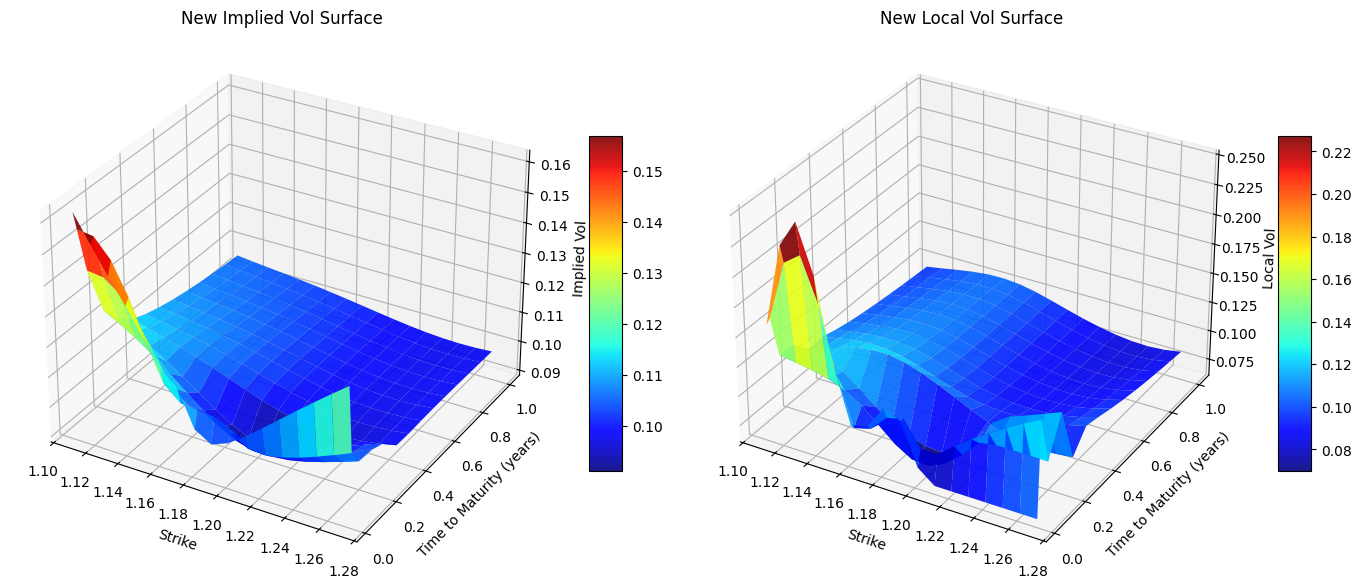

In [219]:
maturities_to_plot = [
    calendar.advance(ref_date, ql.Period(1, ql.Weeks)),
    calendar.advance(ref_date, ql.Period(2, ql.Weeks))] + \
    [calendar.advance(ref_date, ql.Period(i, ql.Months)) for i in range(1, 12, 1)] + \
    [calendar.advance(ref_date, ql.Period(1, ql.Years))]
times_to_plot = [dc.yearFraction(ref_date, m) for m in maturities_to_plot]
strikes_to_plot = np.arange(1.11, 1.28, 0.01)
S, T = np.meshgrid(strikes_to_plot, times_to_plot)

IV = np.zeros_like(T)
LV = np.zeros_like(T)

for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        IV[i, j] = ah_vol_surf.blackVol(T[i, j], S[i, j], True)
        LV[i, j] = ah_local_vol.localVol(T[i, j], S[i, j], True)

fig = plt.figure(figsize=(14, 7))
ax_1 = fig.add_subplot(1,2,1, projection='3d')
ax_2 = fig.add_subplot(1,2,2, projection='3d')

iv_surf = ax_1.plot_surface(S, T, IV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_1.set_xlabel('Strike')
ax_1.set_ylabel('Time to Maturity (years)')
ax_1.set_zlabel('Implied Vol')
ax_1.set_title('New Implied Vol Surface')
fig.colorbar(iv_surf, ax=ax_1, shrink=0.5, aspect=10)

lv_surf = ax_2.plot_surface(S, T, LV, cmap=plt.cm.jet, edgecolor='k', alpha=0.9, linewidth=0.01, antialiased=True)
ax_2.set_xlabel('Strike')
ax_2.set_ylabel('Time to Maturity (years)')
ax_2.set_zlabel('Local Vol')
ax_2.set_title('New Local Vol Surface')
fig.colorbar(lv_surf, ax=ax_2, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


We now have to recalculate the price of the hedging vanillas and the value of the new exotics to calculate the $P\&L$ from time $t$ to time $t+1$

In [ ]:
#| echo: true
for i in range(len(vanilla_options)):
    for j in range(len(vanilla_options[0])):
        process = ql.GarmanKohlagenProcess(
            spot_handle,
            foreign_ts,
            domestic_ts,
            ql.BlackVolTermStructureHandle(
                ql.BlackConstantVol(ref_date, calendar, new_ivs[i, j], dc)
            )
        )
        vanilla_options[i][j].setPricingEngine(ql.AnalyticEuropeanEngine(process))

In [ ]:
#| echo: true
new_premiums = [opt.NPV() for opt in book]
new_book_value = sum(new_premiums)
new_vanilla_premiums = [[opt.NPV() * v_w * notional for opt, v_w in zip(row, v_row)] for row, v_row in zip(vanilla_options, vega_weights)]
spot_premium_eur = hedging_delta_weight * notional 
new_spot_hedge_usd = hedging_delta_weight * notional * spot_handle.value()
new_hedging_str_premium = np.sum(new_vanilla_premiums) + new_spot_hedge_usd


In [ ]:
#| echo: true
dt = dc.yearFraction(today, ref_date)
usd_interest_cost = hedging_str_premium * r_d * dt
eur_interest_accr = spot_premium_eur * r_f * dt

In [ ]:
#| echo: true
new_total_portfolio_value = new_hedging_str_premium - np.sum(new_premiums) + bank_account_value - usd_interest_cost + eur_interest_accr * spot_quote.value()

print(f"Portfolio value at time t = 1 is: ${new_total_portfolio_value}")

Portfolio value at time t = 1 is: $202.86605298389892


Thus the variation from time 0 to time 1 is just about $\$200$, this confirms that our hedge worked by limiting the variation of the whole portfolio value.